In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import statistics
import math
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
# functions from TADE paper, section 4.1

def gaussian_kernel_function(t):
    K = np.exp(-t*t/2) / math.sqrt(2*math.pi)
    return K

def probability_density_estimator(t, time_intervals):
    # bandwidth, silvermans rule of thumb
    h = np.std(time_intervals)*(4/3/len(time_intervals))**(1/5)
    if h == 0.0:
        h = 1.0
    
    add = 0.0
    for n in range(len(time_intervals)):
        k = gaussian_kernel_function((t - time_intervals[n]) / h)
        add += k
    f = add / (len(time_intervals) * h)
    
    return f   

In [3]:
def get_time_intervals(eventlog):

    time_intervals = {}

    caseID_list = eventlog["caseID"].tolist()
    caseID_list = list(dict.fromkeys(caseID_list))

    for caseID in caseID_list:
        sublist = eventlog.loc[eventlog["caseID"]==caseID]
        sublist.reset_index(drop=True, inplace=True)

        BTN_sequence = sublist["BTN_sequence"][0]

        if BTN_sequence in time_intervals:  
            for n in range(len(sublist)-1):
                time_interval =  (sublist["Zeitpunkt"][n+1] - sublist["Zeitpunkt"][0]).total_seconds()
                time_intervals[BTN_sequence][n].append(time_interval)
        else:
            for n in range(len(sublist)-1):
                time_interval =  (sublist["Zeitpunkt"][n+1] - sublist["Zeitpunkt"][0]).total_seconds()
                time_intervals.setdefault(BTN_sequence, {})
                time_intervals[BTN_sequence].setdefault(n, [0])[0] = time_interval
    return time_intervals

#full cartesian
def get_time_intervals_fc(eventlog):

    time_intervals = {}

    caseID_list = eventlog["caseID"].tolist()
    caseID_list = list(dict.fromkeys(caseID_list))

    for caseID in caseID_list:
        sublist = eventlog.loc[eventlog["caseID"]==caseID]
        sublist.reset_index(drop=True, inplace=True)

        BTN_sequence = sublist["BTN_sequence"][0]

        if BTN_sequence in time_intervals: 
            number = 0
            for n in range(len(sublist)-1):
                time_bigger = sublist["Zeitpunkt"][n+1]
                for m in range(n+1):
                    time_smaller = sublist["Zeitpunkt"][m]
                    time_interval = (time_bigger - time_smaller).total_seconds()
                    time_intervals[BTN_sequence][number].append(time_interval)
                    number += 1
            
        else:
            number = 0
            for n in range(len(sublist)-1):
                time_bigger = sublist["Zeitpunkt"][n+1]
                for m in range(n+1):
                    time_smaller = sublist["Zeitpunkt"][m]
                    time_interval = (time_bigger - time_smaller).total_seconds()
                    time_intervals.setdefault(BTN_sequence, {})
                    time_intervals[BTN_sequence].setdefault(number, [0])[0] = time_interval
                    number += 1
                
    return time_intervals

In [4]:
def test_fitness(eventlog, time_intervals):

    fitness_score = {}

    caseID_list = eventlog["caseID"].tolist()
    caseID_list = list(dict.fromkeys(caseID_list))
    
    for caseID in caseID_list:
        sublist = eventlog.loc[eventlog["caseID"]==caseID]
        sublist.reset_index(drop=True, inplace=True)

        BTN_sequence = sublist["BTN_sequence"][0]

        conf_scores = []

        if BTN_sequence in time_intervals:  
            for n in range(len(sublist)-1):
                t =  (sublist["Zeitpunkt"][n+1] - sublist["Zeitpunkt"][0]).total_seconds()
                time_interval = time_intervals[BTN_sequence][n]
                estimate = probability_density_estimator(t, time_interval) 
                conf_scores.append(estimate)
            result = np.mean(conf_scores)
        else:
            result = 0

        fitness_score[caseID] = result
        #print(result)
        
    return fitness_score


def test_fitness_fc(eventlog, time_intervals):

    fitness_score = {}

    caseID_list = eventlog["caseID"].tolist()
    caseID_list = list(dict.fromkeys(caseID_list))
    
    for caseID in caseID_list:
        sublist = eventlog.loc[eventlog["caseID"]==caseID]
        sublist.reset_index(drop=True, inplace=True)

        BTN_sequence = sublist["BTN_sequence"][0]

        conf_scores = []

        if BTN_sequence in time_intervals: 
            number = 0
            for n in range(len(sublist)-1):
                time_bigger = sublist["Zeitpunkt"][n+1]
                for m in range(n+1):
                    time_smaller = sublist["Zeitpunkt"][m]
                    t = (time_bigger - time_smaller).total_seconds()
                    time_interval = time_intervals[BTN_sequence][number]                 
                    estimate = probability_density_estimator(t, time_interval) 
                    number += 1
                    conf_scores.append(estimate)
            result = np.mean(conf_scores)
        else:
            result = 0

        fitness_score[caseID] = result
        #print(result)

    return fitness_score

### kernel density estimate

In [7]:
array1 = [1,2,3,4,5,6,7,8,9,10]
for number in array1:
    estimate = probability_density_estimator(number, array1)
    print(estimate)

0.06039116329261482
0.07853622831223556
0.09061033776035167
0.09671170217916474
0.09892507029986503
0.09892507029986503
0.09671170217916474
0.09061033776035167
0.07853622831223556
0.06039116329261482


In [9]:
array2 = [5,5,5,5,5,5,5,5,5,5]
for number in array2:
    estimate = probability_density_estimator(number, array2)
    print(estimate)

0.3989422804014327
0.3989422804014327
0.3989422804014327
0.3989422804014327
0.3989422804014327
0.3989422804014327
0.3989422804014327
0.3989422804014327
0.3989422804014327
0.3989422804014327


In [10]:
1 / math.sqrt(2*math.pi)

0.3989422804014327

In [ ]:
# A demostration of the kernel density estimator from TADE paper section 4.1
# So when the data has REALLY small deviation, the estimates are relatively big
# An extreme example is array2 here, the results are equal to 1 / math.sqrt(2*math.pi)
# And in case of real data with bigger deviation, the estimates can be really small, as the calculated fitness scores below
# So in general, we wouldn't want the fitness score of a case to be 1 to say that this case conforms

### our eventlog and visualization of time intervals

In [5]:
# merged log with numerical and sequential anomalies deleted
eventlog = pd.read_csv("merged_log.csv")
eventlog['Zeitpunkt'] = pd.to_datetime(eventlog['Zeitpunkt'])
eventlog

,caseID,BTN,Funkadresse,Odometer,Zeitpunkt,BTN_sequence,Anzahl_der_Telegramme,LAT,LON,LAT_SOLL,LON_SOLL
0,54_17_146_200317_40879020,5840,833,45677,2020-03-17 08:53:48,5840__5841__5842_,3,"48,10984167","11,58868167","48,109819","11,588789"
1,54_17_146_200317_40879020,5841,833,45767,2020-03-17 08:53:58,5840__5841__5842_,3,"48,11000333","11,587605","48,109972","11,587744"
2,54_17_146_200317_40879020,5842,833,45910,2020-03-17 08:54:15,5840__5841__5842_,3,"48,11053167","11,58568667","48,110481","11,58587"
3,54_17_1142_200317_40879020,45680,833,46014,2020-03-17 08:54:27,45680__45681__45682_,3,"48,11089167","11,58437667","48,110845","11,58455"
4,54_17_1142_200317_40879020,45681,833,46151,2020-03-17 08:54:41,45680__45681__45682_,3,"48,11135","11,58279167","48,111312","11,582909"
...,...,...,...,...,...,...,...,...,...,...,...
70306,54_1_159_200317_40788477,6382,805,65294,2020-03-17 18:46:05,6377__6378__6381__6382_,4,"48,11222833","11,50231333","48,11221","11,50248"
70307,54_1_417_200317_40788477,16681,805,65326,2020-03-17 18:46:11,16681__16682__16689__16690_,4,"48,11223167","11,50177833","48,112196","11,501868"
70308,54_1_417_200317_40788477,16682,805,65356,2020-03-17 18:46:33,16681__16682__16689__16690_,4,"48,11222167","11,50138","48,112194","11,501531"
70309,54_1_417_200317_40788477,16689,805,65624,2020-03-17 18:46:58,16681__16682__16689__16690_,4,"48,11224","11,49778667","48,112234","11,498008"


In [15]:
# full cartesian
time_intervals_fc = get_time_intervals_fc(eventlog)
fitness_scores_fc = test_fitness_fc(eventlog, time_intervals_fc)

In [16]:
BTN_sequence_list = eventlog["BTN_sequence"].tolist()
BTN_sequence_list = list(dict.fromkeys(BTN_sequence_list))
BTN_sequence_list

# B_list is a list of BTN sequences with more than 10 cases
# as some BTN sequences only has several cases in the given data

B_list = []
for sequence in BTN_sequence_list:
    sublog = eventlog[eventlog["BTN_sequence"]==sequence]
    cases_list = sublog["caseID"].tolist()
    cases_list = list(dict.fromkeys(cases_list))
    if len(cases_list)>10:
        B_list.append(sequence)
        
B_list

['5840__5841__5842_',
 '45680__45681__45682_',
 '49720__49721_',
 '5412__5413__5414_',
 '37656__37657__37658__37659_',
 '28292__28293__28294_',
 '8452__8453__8454_',
 '8460__8461__8462_',
 '28304__28305__28306__28302_',
 '3856__3857__3858_',
 '8896__8897__8898_',
 '37660__37661__37662__37663_',
 '5426__5429__5430_',
 '3316__3317__3318_',
 '6284__6285__6286__6287__6288_',
 '45684__45685__45686_',
 '5844__5845__5846_',
 '11664__11665_',
 '3320__3321__3322__3323_',
 '8880__8881__8882__8883_',
 '35171__35170__35169_',
 '27605__27606__27607_',
 '30850__30849__30848_',
 '23444__23445__23446_',
 '42764__42762__42761__42760_',
 '22400__22401__22402_',
 '6776__6777__6778__6779_',
 '28092__28093__28094_',
 '50096__50097__50098__50099_',
 '11416__11417__11418__11419_',
 '11329__11330__11333__11334_',
 '48804__48805__48806_',
 '11305__11292__11293__11306__11294_',
 '9288__9289__9290_',
 '8372__8373__8374__8375_',
 '4536__4537__4540__4541__4542_',
 '460__461__462__463__464_',
 '2768__2769__2792_',


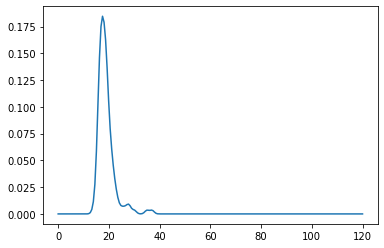

In [30]:
# visualization of time intervals
# substitute BTN sequence here
sequence = "5840__5841__5842_"
dict_length = len(time_intervals_fc[sequence])
# with array_length-1 it returns the last array of the dictionary, 
# which is the time interval between the last 2 telegrams, normally the 2 with traffic light in between
times = list(time_intervals_fc[sequence][dict_length-1]) 
density = gaussian_kde(times)
xs = np.linspace(0,120,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()